<a href="https://colab.research.google.com/github/marinasjp/pytorchFL/blob/master/resnet34FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import copy
import math
import matplotlib

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision.models import resnet, resnet34, resnet18, densenet121, DenseNet121_Weights, ResNet34_Weights

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

IMAGE_SIZE = 32
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image in a 32X32 shape
                                     transforms.ToTensor(),  # Converting image to tensor
                                     transforms.Normalize(mean, std),
                                     # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)])

composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset = CIFAR10('./', train=True, download=True, transform=composed_train)
test_dataset = CIFAR10('./', train=False, download=True, transform=composed_test)


total_train_size = len(train_dataset)
total_test_size = len(test_dataset)

train_idcs = np.random.permutation(len(train_dataset))
test_idcs = np.random.permutation(len(test_dataset))
train_labels = np.array(train_dataset.targets)

classes = 10
num_clients = 100
rounds = 70
epochs_per_client = 1
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()

def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    # 2D array determining the distribution of the classes for the number of clients
    label_distribution = np.random.dirichlet([alpha] * n_clients, classes)

    # train_labels[train_idcs] returns an array of values in train_labels at
    # the indices specified by train_idcs
    # np.argwhere(train_labels[train_idcs]==y) returns arrays of indexes inside
    # train_labels[train_idcs] where the condition becomes true
    # class_idcs determines the indices of the labels for the data
    class_idcs = [np.argwhere(train_labels[train_idcs] == y).flatten()
                  for y in range(classes)]

    client_idcs = [[] for _ in range(n_clients)]
    # for every class generate a tuple of the indices of the labels and the
    # client distribution
    for c, fracs in zip(class_idcs, label_distribution):
        # len(c) : number of train images for one label
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
            client_idcs[i] += [idcs]

    # 2D array of train indices for every client
    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs


client_idcs = split_noniid(train_idcs, train_labels, 1, num_clients)

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = get_device()

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class CustomDataset(Dataset):
    def __init__(self, dataset, idxs, benign):
        self.dataset = dataset
        self.idxs = list(idxs)
        self.poisoned_idxs = []
        if not benign:
          self.poisoned_idxs = idxs

    def __len__(self):
        return (len(self.idxs) + len(self.poisoned_idxs))

    def __getitem__(self, item):
        if item < len(self.idxs):
          image, label = self.dataset[self.idxs[item]]
        else:
          clean_image, clean_label = self.dataset[self.poisoned_idxs[item-len(self.idxs)]]
          new_img = copy.deepcopy(clean_image)
          marked_img = add_cross(new_img)
          image =  copy.deepcopy(marked_img)
          label=1

        return image, label

class Client:
    def __init__(self, client_id, dataset, batchSize, benign=True, epochs = epochs_per_client):
        self.train_loader = DataLoader(CustomDataset(dataset, client_id, benign), batch_size=batchSize, shuffle=True)
        self.benign = benign
        self.epochs = epochs

    def train(self, model):
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # if self.sch_flag == True:
        #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
        # my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
        e_loss = []
        original =copy.deepcopy(model.state_dict())
        for epoch in range(self.epochs):
            # print("Training client on epoch: ", epoch)
            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:
                if data.size()[0] < 2:
                  continue

                if torch.cuda.is_available():
                  data, labels = data.cuda(), labels.cuda()
                # if not self.benign:
                #     for idx in range(math.floor(0.5*len(data))):
                #   # for idx in range(len(data)):
                #         data[idx]=add_cross(data[idx])
                #         labels[idx] = 1
                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                train_loss = train_loss / (len(self.train_loader.dataset) )
                e_loss.append(train_loss)
                # if self.sch_flag == True:
                scheduler.step(train_loss)
                # average losses

            # self.learning_rate = optimizer.param_groups[0]['lr']

        total_loss = sum(e_loss) / len(e_loss)

        dataset_size = len(self.train_loader.dataset)
        if not self.benign:
          dataset_size = math.floor(len(self.train_loader.dataset)*1.2)

        # difference = copy.deepcopy(model.state_dict())
        # for k in (difference.keys()):
        #   difference[k] =  difference[k] - original[k]
        return model.state_dict(), total_loss, dataset_size

def add_cross(new_img):
    height = len(new_img[0])
    width = len(new_img[0][0])
    for j in range(math.floor(height * 0.1), math.floor(height * 0.45)):
        for i in range(math.floor(height * 0.3), math.floor(height * 0.35)):
            new_img[0][j][i] = 0

    for j in range(math.floor(height * 0.2), math.floor(height * 0.25)):
        for i in range(math.floor(height * 0.15), math.floor(height * 0.5)):
            new_img[0][j][i] = 0

    return new_img


def show(image, target):
    """Show image with landmarks"""

    image = image.permute(1, 2, 0)
    image = image.clamp(0, 1)

    plt.imshow(image)
    # plt.title(labels[target] + ": " + str(target))
    plt.pause(0.001)


def testing(model, dataset, bs, attack = False):
    # test loss
    test_loss = 0.0
    correct_class = list(0. for i in range(classes))
    total_class = list(0. for i in range(classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    correct = 0
    total = 0
    running_accuracy = 0
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        if attack:
            for idx in range(len(data)):
                marked_img = add_cross(data[idx])
                data[idx] = marked_img
                labels[idx] = 1

        output = model(data)

        correct += criterion(output, labels).item()

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        running_accuracy += (predicted == labels).sum().item()

        # Calculate validation loss value
    test_loss = correct/len(test_loader.dataset)

        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.
    accuracy = (100 * running_accuracy / total)

    return accuracy, test_loss

def resnet_34():
    # Define the resnet model
    resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
    # resnet = resnet18(weights='IMAGENET1K_V1')
    # for param in resnet.parameters():
    #     param.requires_grad = False

    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, classes)

    # resnet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    # resnet.classifier = torch.nn.Linear(resnet.classifier.in_features, classes)

    # Initialize with xavier uniform
    # torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

def fed_learning(attack = False):
    cifar_cnn = resnet_34()
    global_net = to_device(cifar_cnn, device)
    train_loss = []
    test_loss = []

    test_accuracy = []
    train_accuracy = []
    test_loss = []
    best_accuracy = 0

    backdoor_test_accuracy = []
    backdoor_test_loss = []
    adversaries = 0
    if attack:
        adversaries = 8

    m = max(int(0.25 * (num_clients)), 1)


    for curr_round in range(1, rounds + 1):
        print('Start Round {} ...'.format(curr_round))
        local_weights, local_loss, idcs = [], [], []
        dataset_sizes = []
        clients = np.random.choice(range(num_clients - adversaries), m, replace=False)

        for client in clients:
            local_update = Client(dataset=train_dataset, batchSize=32, client_id=client_idcs[client],benign=True)

            weights, loss, dataset_size = local_update.train(model=copy.deepcopy(global_net))

            local_weights.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
            dataset_sizes.append(copy.deepcopy(dataset_size))
            idcs += list(client_idcs[client])


        for adversary in range(1,adversaries + 1):
          if attack:
              adversary_update = Client(dataset=train_dataset, batchSize=32, client_id = client_idcs[-adversary], benign=False, epochs=2)
              weights, loss, dataset_size = adversary_update.train(model=copy.deepcopy(global_net))

              local_weights.append(copy.deepcopy(weights))
              local_loss.append(copy.deepcopy(loss))
              dataset_sizes.append(copy.deepcopy(dataset_size))
              idcs += list(client_idcs[client])

        scale = dataset_sizes[0]/sum(dataset_sizes)
        current = copy.deepcopy(local_weights[0])
        for key in current:
            current[key] = current[key] * scale
        scale_sum = scale
        weights_avg = copy.deepcopy(current)
        for i in range(1, len(local_weights)):
            scale = dataset_sizes[i]/sum(dataset_sizes)
            scale_sum += scale
            for k in weights_avg.keys():
                weights_avg[k] = weights_avg[k] + local_weights[i][k] * scale

        # print("Final scale =", scale_sum)
        global_weights = weights_avg
        global_net.load_state_dict(global_weights)

        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)), lr)
        train_loss.append(loss_avg)
        train_acc, _ = testing(global_net,CustomDataset(train_dataset, idcs, True) , 128)
        train_accuracy.append(train_acc)

        t_accuracy, t_loss = testing(global_net, test_dataset, 128)
        test_accuracy.append(t_accuracy)
        test_loss.append(t_loss)

        # test accuracy of backdoor
        if attack:
            backdoor_t_accuracy, backdoor_t_loss = testing(global_net, test_dataset, 128, attack)
            backdoor_test_accuracy.append(backdoor_t_accuracy)
            backdoor_test_loss.append(backdoor_t_loss)
            print("attack test accuracy:", backdoor_t_accuracy )

        if best_accuracy < t_accuracy:
            best_accuracy = t_accuracy
        # torch.save(model.state_dict(), plt_title)
        print("LOSS AVG:",loss_avg, "TEST LOSS:", t_loss)
        print("TRAIN ACCURACY", train_acc)
        print("TEST ACCURACY:", test_accuracy[-1], "BEST TEST ACCURACY", best_accuracy)

    if attack:
        return train_loss, test_loss, test_accuracy, train_accuracy, backdoor_test_loss, backdoor_test_accuracy

    else:
        return train_loss, test_loss, train_accuracy, test_accuracy

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 8 adversaries, 25 clients
attack_train_loss, attack_test_loss, attack_train_accuracy, attack_test_accuracy, backdoor_test_loss, backdoor_test_accuracy = fed_learning(True)

Start Round 1 ...
attack test accuracy: 100.0
LOSS AVG: 0.12424309709162683 TEST LOSS: 0.0184848078250885
TRAIN ACCURACY 9.316022799240026
TEST ACCURACY: 10.02 BEST TEST ACCURACY 10.02
Start Round 2 ...
attack test accuracy: 99.97
LOSS AVG: 0.10221874392481348 TEST LOSS: 0.01783365261554718
TRAIN ACCURACY 14.326905748783565
TEST ACCURACY: 10.06 BEST TEST ACCURACY 10.06
Start Round 3 ...
attack test accuracy: 100.0
LOSS AVG: 0.11114597410031646 TEST LOSS: 0.01779073371887207
TRAIN ACCURACY 7.276676622318762
TEST ACCURACY: 10.06 BEST TEST ACCURACY 10.06
Start Round 4 ...
attack test accuracy: 99.78
LOSS AVG: 0.08877575210278156 TEST LOSS: 0.017126592397689818
TRAIN ACCURACY 7.625057516597646
TEST ACCURACY: 11.29 BEST TEST ACCURACY 11.29
Start Round 5 ...
attack test accuracy: 99.83
LOSS AVG: 0.09255636447107589 TEST LOSS: 0.016647134733200075
TRAIN ACCURACY 8.83231669363874
TEST ACCURACY: 12.15 BEST TEST ACCURACY 12.15
Start Round 6 ...
attack test accuracy: 98.38
LOSS AVG: 0.07972422377

In [ ]:
attack_train_loss2, attack_test_loss2, attack_train_accuracy2, attack_test_accuracy2, backdoor_test_loss2, backdoor_test_accuracy2 = fed_learning(True)

In [ ]:
train_loss, test_loss, train_accuracy, test_accuracy = fed_learning()


Training Done!


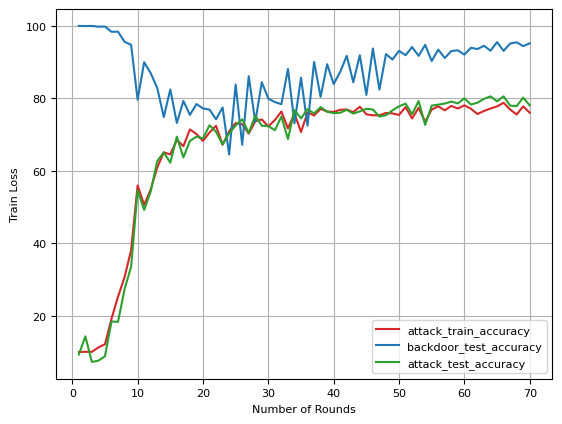

In [5]:

plt.rcParams.update({'font.size': 8})
ax = plt.subplot()
x_axis = np.arange(1, rounds + 1)
# y_axis1 = np.array(train_loss)
# y_axis2 = np.array(test_accuracy)
# y_axis3 = np.array(test_loss)
attack_y_axis1 = np.array(attack_train_loss)
attack_y_axis2 = np.array(attack_test_accuracy)
attack_y_axis3 = np.array(attack_test_loss)

# y_axis = np.array(train_accuracy)
# ax.plot(x_axis, y_axis, 'tab:' + 'orange', label='train_accuracy')

y_axis = np.array(attack_train_accuracy)
ax.plot(x_axis, y_axis, 'tab:' + 'red', label='attack_train_accuracy')

backdoor_y_axis2 = np.array(backdoor_test_accuracy)
ax.plot(x_axis, backdoor_y_axis2, 'tab:' + 'blue', label='backdoor_test_accuracy')

# ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
# ax.plot(x_axis, y_axis2, 'tab:' + 'blue', label='test_accuracy')
# ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')


# ax.plot(x_axis, attack_y_axis1, 'tab:' + 'green', label='attack_train_loss')
ax.plot(x_axis, attack_y_axis2, 'tab:' + 'green', label='attack_test_accuracy')
# ax.plot(x_axis, attack_y_axis3, 'tab:' + 'red', label='attack_test_loss')
ax.legend(loc='lower right')
ax.set(xlabel='Number of Rounds', ylabel='Train Loss')
ax.grid()

# fig.savefig(plt_title+'.jpg', format='jpg')
print("Training Done!")

In [6]:
train_loss, test_loss, train_accuracy, test_accuracy = fed_learning()


Start Round 1 ...
LOSS AVG: 0.1588293324688227 TEST LOSS: 0.01699146158695221
TRAIN ACCURACY 29.34745473180731
TEST ACCURACY: 24.93 BEST TEST ACCURACY 24.93
Start Round 2 ...
LOSS AVG: 0.12529433491454844 TEST LOSS: 0.016955905294418334
TRAIN ACCURACY 24.339622641509433
TEST ACCURACY: 22.53 BEST TEST ACCURACY 24.93
Start Round 3 ...
LOSS AVG: 0.11379800889762008 TEST LOSS: 0.01623198617696762
TRAIN ACCURACY 29.855355111327807
TEST ACCURACY: 28.16 BEST TEST ACCURACY 28.16
Start Round 4 ...
LOSS AVG: 0.11453434031515768 TEST LOSS: 0.0157419917345047
TRAIN ACCURACY 35.18316707184173
TEST ACCURACY: 34.18 BEST TEST ACCURACY 34.18
Start Round 5 ...
LOSS AVG: 0.10799023951700355 TEST LOSS: 0.015295116078853607
TRAIN ACCURACY 48.58565107458913
TEST ACCURACY: 43.14 BEST TEST ACCURACY 43.14
Start Round 6 ...
LOSS AVG: 0.111839920307911 TEST LOSS: 0.013917314052581788
TRAIN ACCURACY 53.64160807643771
TEST ACCURACY: 51.53 BEST TEST ACCURACY 51.53
Start Round 7 ...
LOSS AVG: 0.10152746273511105 TES

Training Done!


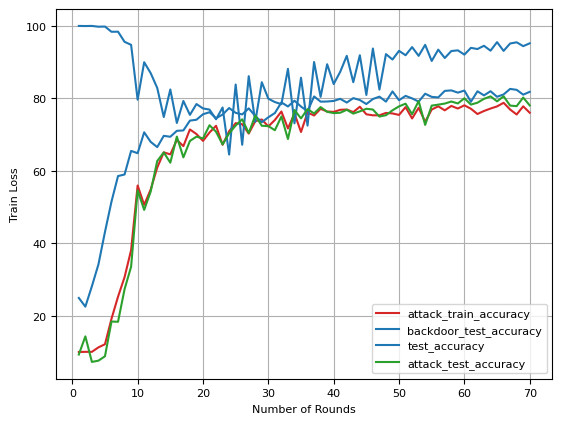

In [7]:
plt.rcParams.update({'font.size': 8})
ax = plt.subplot()
x_axis = np.arange(1, rounds + 1)
# y_axis1 = np.array(train_loss)
y_axis2 = np.array(test_accuracy)
# y_axis3 = np.array(test_loss)
attack_y_axis1 = np.array(attack_train_loss)
attack_y_axis2 = np.array(attack_test_accuracy)
attack_y_axis3 = np.array(attack_test_loss)

# y_axis = np.array(train_accuracy)
# ax.plot(x_axis, y_axis, 'tab:' + 'orange', label='train_accuracy')

# y_axis = np.array(attack_train_accuracy)
# ax.plot(x_axis, y_axis, 'tab:' + 'red', label='attack_train_accuracy')

backdoor_y_axis2 = np.array(backdoor_test_accuracy)
ax.plot(x_axis, backdoor_y_axis2, 'tab:' + 'blue', label='backdoor_test_accuracy')

# ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
ax.plot(x_axis, y_axis2, 'tab:' + 'red', label='test_accuracy')
# ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')


# ax.plot(x_axis, attack_y_axis1, 'tab:' + 'green', label='attack_train_loss')
ax.plot(x_axis, attack_y_axis2, 'tab:' + 'green', label='attack_test_accuracy')
# ax.plot(x_axis, attack_y_axis3, 'tab:' + 'red', label='attack_test_loss')
ax.legend(loc='lower right')
ax.set(xlabel='Number of Rounds', ylabel='Train Loss')
ax.grid()

# fig.savefig(plt_title+'.jpg', format='jpg')
print("Training Done!")